# Necessary imports and data load

In [1]:
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import xyzservices.providers as xyz


df = pd.read_csv('./otpdata/itineraries.csv', sep = ';')
df['legs'] = df['legs'].apply(ast.literal_eval)
df['route_coordinates'] = df['route_coordinates'].apply(ast.literal_eval)
rt_df = pd.read_csv('./otpdata/rt_itineraries.csv', sep = ';')
rt_df['legs'] = rt_df['legs'].apply(ast.literal_eval)
rt_df['route_coordinates'] = rt_df['route_coordinates'].apply(ast.literal_eval)

In [2]:
print(df.columns)
df.head(1)

Index(['response_nr', 'requestParameters.date', 'requestParameters.time',
       'plan.from.lon', 'plan.from.lat', 'plan.to.lon', 'plan.to.lat',
       'itinerary_nr', 'duration', 'startTime', 'endTime', 'walkTime',
       'transitTime', 'waitingTime', 'walkDistance', 'walkLimitExceeded',
       'generalizedCost', 'transfers', 'legs', 'location_from_name',
       'location_to_name', 'route_coordinates', 'route_coordinates_str'],
      dtype='object')


,response_nr,requestParameters.date,requestParameters.time,plan.from.lon,plan.from.lat,plan.to.lon,plan.to.lat,itinerary_nr,duration,startTime,...,waitingTime,walkDistance,walkLimitExceeded,generalizedCost,transfers,legs,location_from_name,location_to_name,route_coordinates,route_coordinates_str
0,0,2022-03-30,6:30am,21.053933,52.234521,21.090498,52.165201,0,2881,2022-03-30 04:35:52,...,459,1019.98,True,5414,2,"[{'startTime': 1648614952000, 'endTime': 16486...",francuska,muzeum_wilanow,"[[21.05398, 52.23453], [21.05396, 52.23456], [...","[[21.05398, 52.23453], [21.05396, 52.23456], [..."


# drawing the route

### start and end points for routes

In [ ]:
mapping = {
    'francuska': 'ul. francuska',
    'palac_krolewski_stare_miasto': 'Pałac Królewski - Stare Miasto',
    'mordor': 'Galeria Mokotów',
    'pkin': 'PKiN',
    'sokowirówka_wilanów': 'Świątynia Opatrzności - Wilanów',
    'muzeum_kopernika': 'Muzeum Kopernika',
    'powazki': 'cmentarz Powązki',
    'stadion_narodowy': 'Stadion Narodowy',
    'lotnisko': 'Lotnisko Chopina',
    'muzeum_wilanow' : 'Muzeum Wilanów',
    'muzeum_powstania' : 'Muzeum Powstania Warszawskiego',
    'wyscigi_konne_sluzew' : 'Tor Wyścigów Konnych - Służew',
    'promenada' : 'Promenada'
}

df['location_from_name'] = df['location_from_name'].replace(mapping)
df['location_to_name'] = df['location_to_name'].replace(mapping)
rt_df['location_from_name'] = rt_df['location_from_name'].replace(mapping)
rt_df['location_to_name'] = rt_df['location_to_name'].replace(mapping)

### code supplied by separate engineering project
decodes encoded poliline

In [3]:
def decode(point_str):
    coord_chunks = [[]]
    
    for char in point_str:
        value = ord(char) - 63
        split_after = not (value & 0x20)
        value &= 0x1F
        coord_chunks[-1].append(value)
        
        if split_after:
            coord_chunks.append([])
    
    coord_chunks.pop()

    coords = []

    for coord_chunk in coord_chunks:
        coord = 0

        for i, value in enumerate(coord_chunk):
            coord |= value << (i * 5)

        if coord & 0x1:
            coord = ~coord
        coord >>= 1
        coord /= 100000.0

        coords.append(coord)

    points = []
    prev_x, prev_y = 0, 0

    for i in range(0, len(coords) - 1, 2):
        if coords[i] == 0 and coords[i + 1] == 0:
            continue

        prev_x += coords[i + 1]
        prev_y += coords[i]
        points.append([round(prev_x, 6), round(prev_y, 6)])

    return points

### display example routes and endpoints
example of the data used for further analysis

(2328577.629679609, 2357929.448541117) (6819405.915490285, 6848757.734351791)


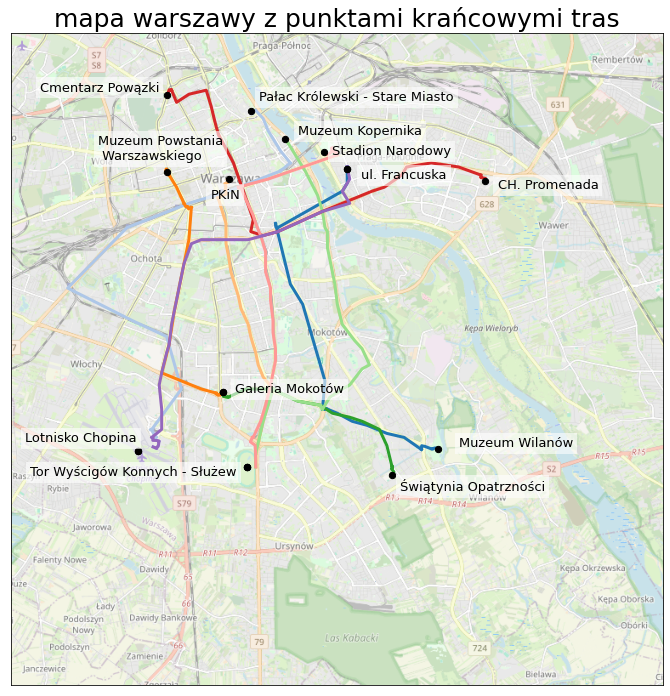

In [ ]:
import contextily as ctx
import matplotlib.pyplot as plt
import xyzservices.providers as xyz
import pyproj
from matplotlib.colors import ListedColormap

target_crs = 'EPSG:3857'
transformer = pyproj.Transformer.from_crs('EPSG:4326', target_crs)
subset = df[['plan.from.lat', 'plan.from.lon', 'plan.to.lat', 'plan.to.lon', 'location_from_name', 'location_to_name']].drop_duplicates()
lons = [20.85, 21.1]
lats = [52.1, 52.3]
lats = list(subset['plan.from.lat']) + list(subset['plan.to.lat'])
lons = list(subset['plan.from.lon']) + list(subset['plan.to.lon'])


# Bounding box
min_lon = min(lons)-0.05
max_lon = max(lons)
min_lat = min(lats)
max_lat = max(lats)

# Get the background image and extent using ctx.bounds2img
warsaw_img, warsaw_extent = ctx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=ctx.providers.OpenStreetMap.Mapnik)
# Plot the basemap
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(warsaw_img, extent=warsaw_extent, alpha = 0.65)

l = ax.get_xlim()[0]
u = ax.get_ylim()[1]
spread = ax.get_xlim()[1] - l

alpha = 0.6
fontsize = 13
# Choose a colormap (e.g., 'viridis', 'plasma', 'inferno', 'magma', etc.)

plt.annotate('ul. Francuska', (l + spread * 360/670, u - spread * 150/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('CH. Promenada', (l + spread * 500/670, u - spread * 160/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Muzeum Wilanów', (l + spread * 460/670, u - spread * 425/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Świątynia Opatrzności', (l + spread * 400/670, u - spread * 470/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Tor Wyścigów Konnych - Służew', (l + spread * 20/670, u - spread * 455/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Galeria Mokotów', (l + spread * 230/670, u - spread * 370/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Lotnisko Chopina', (l + spread * 15/670, u - spread * 420/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Muzeum Powstania\n Warszawskiego', (l + spread * 90/670, u - spread * 130/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Cmentarz Powązki', (l + spread * 30/670, u - spread * 60/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Pałac Królewski - Stare Miasto', (l + spread * 255/670, u - spread * 70/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Muzeum Kopernika', (l + spread * 295/670, u - spread * 105/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('PKiN', (l + spread * 205/670, u - spread * 170/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))
plt.annotate('Stadion Narodowy', (l + spread * 330/670, u - spread * 125/670), fontsize=fontsize, bbox=dict(facecolor='white', alpha = alpha, edgecolor='none'))


cmap_name = 'tab20'
cmap = plt.get_cmap(cmap_name)
# Plot the background image 
c = 0
for i, row in subset.iterrows():
    # plt.plot([projected_lat, projected_lat2], [projected_lon, projected_lon2], linewidth = 1, c = 'red')
    # plt.plot([projected_lat, projected_lat2], [projected_lon, projected_lon2], linewidth = 1, c = 'red')
    # plt.annotate(f'{row["location_from_name"].replace("_", " ")}',(projected_lat, projected_lon), textcoords="offset points", xytext=(10,-5), fontsize=15)
    # plt.annotate(f'{row["location_to_name"].replace("_", " ")}',(projected_lat2, projected_lon2), textcoords="offset points", xytext=(10,-5), fontsize=15)
    # plt.plot([projected_lat, projected_lat2], [projected_lon, projected_lon2], linewidth = 1, c = 'red')
    
    for legs in df.iloc[[i]]['legs']:
        for leg in legs:
            lats, lons = zip(*decode((leg['legGeometry'])['points']))
            lon_lat_pairs = list(zip(lons, lats))
            projected_coords = [transformer.transform(lon, lat) for lon, lat in lon_lat_pairs]
            projected_lons, projected_lats = zip(*projected_coords)
            plt.plot(projected_lons, projected_lats, linewidth = 3, c = cmap.colors[c], alpha = 1, zorder = 1)    
    c+=1

for i, row in subset.iterrows():
    projected_lat, projected_lon = transformer.transform(row['plan.from.lat'], row['plan.from.lon'])
    projected_lat2, projected_lon2 = transformer.transform(row['plan.to.lat'], row['plan.to.lon'])
    plt.scatter(projected_lat, projected_lon, color = 'black', s = 40, zorder=2)
    plt.scatter(projected_lat2, projected_lon2, color = 'black', s = 40, zorder=2)

plt.grid(False)
plt.xticks([])
plt.yticks([])
plt.title('mapa warszawy z punktami krańcowymi tras', fontsize = 25)
print(ax.get_xlim(), ax.get_ylim())
plt.savefig('../outputs/OTP/benchmark/startpoints.png', dpi = 200)
plt.show()

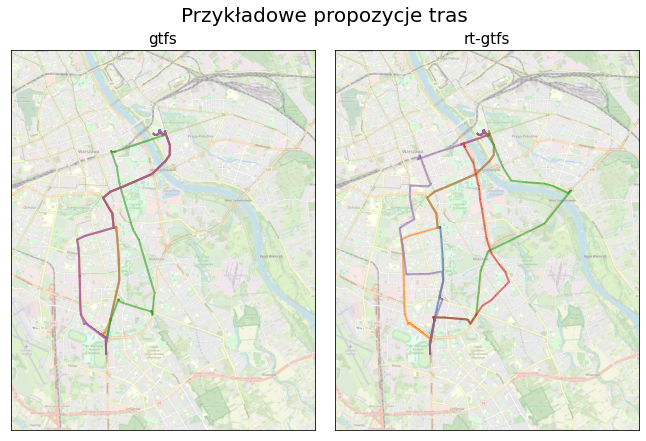

In [4]:
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import xyzservices.providers as xyz
import pyproj

target_crs = 'EPSG:3857'
transformer = pyproj.Transformer.from_crs('EPSG:4326', target_crs)


lons = [21, 21.10]
lats = [52.15, 52.25]

# Bounding box
min_lon = min(lons)
max_lon = max(lons)
min_lat = min(lats)
max_lat = max(lats)

# Get the background image and extent using ctx.bounds2img
warsaw_img, warsaw_extent = ctx.bounds2img(min_lon, min_lat, max_lon, max_lat, ll=True, source=ctx.providers.OpenStreetMap.Mapnik)


cmap_name = 'tab20'
cmap = plt.get_cmap(cmap_name)
cmap = cmap.colors
# Plot the basemap

fig, ax = plt.subplots(1,2, figsize=(9, 6), sharex=True)
fig.subplots_adjust(left=0, bottom=0, right=1, top=None, wspace=0, hspace=0)

# Plot the background image
ax[0].imshow(warsaw_img, extent=warsaw_extent, alpha = 0.65)
ax[1].imshow(warsaw_img, extent=warsaw_extent, alpha = 0.65)
# Plot the route data
tmp = 4
for i, legs in enumerate(df[df['response_nr'] == 4202]['legs']):
    color = cmap[2*i]
    for leg in legs:
        lats, lons = zip(*decode((leg['legGeometry'])['points']))
        lon_lat_pairs = list(zip(lons, lats))
        projected_coords = [transformer.transform(lon, lat) for lon, lat in lon_lat_pairs]
        projected_lons, projected_lats = zip(*projected_coords)
        ax[0].plot(projected_lons, projected_lats, marker=',', linestyle='-', color=color, alpha = 0.6, linewidth = 2)
for i, legs in enumerate(rt_df[rt_df['response_nr'] == 3895]['legs']):
    # if i != tmp:
    #     continue
    color = cmap[2*i]
    for leg in legs:
        lats, lons = zip(*decode((leg['legGeometry'])['points']))
        lon_lat_pairs = list(zip(lons, lats))
        projected_coords = [transformer.transform(lon, lat) for lon, lat in lon_lat_pairs]
        projected_lons, projected_lats = zip(*projected_coords)
        ax[1].plot(projected_lons, projected_lats, marker=',', linestyle='-', color=color, alpha = 0.6, linewidth = 2)

plt.suptitle('Przykładowe propozycje tras', fontsize = 20)
for axes in ax:
    axes.set_xticks([])
    axes.set_yticks([])
plt.grid(False)
ax[0].set_title('gtfs', fontsize = 15)
ax[1].set_title('rt-gtfs', fontsize = 15)

plt.show()

### transformation essential to analyse ONLY the routes with transfers 
(direct connections usually meant too much time spent walking)

In [13]:
df = df[df['transfers'] > 0]
rt_df = rt_df[rt_df['transfers'] > 0]

# EDA

			gtfs	rt-gtfs	t-test p-value
waitingTime		316s	 331s	2.6102995166228615e-07
duration		3245s	 3390s	3.572322160812231e-61
transitTime		1860s	 1920s	4.887309244923811e-25
walkTime		1069s	 1139s	1.3743669857769233e-27


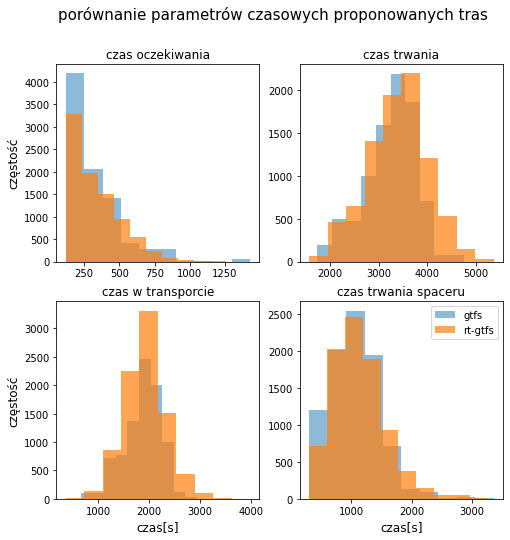

In [14]:
from scipy.stats import ttest_ind
fig, axes = plt.subplots(2,2)
fig.set_size_inches(8,8)

cmap_name = 'tab20'
cmap = plt.get_cmap(cmap_name)
cmap = cmap.colors
d = {
    'waitingTime': 'czas oczekiwania',
    'duration': 'czas trwania',
    'transitTime': 'czas w transporcie',
    'walkTime': 'czas trwania spaceru'
}

for ax, colname in zip(np.asarray(axes).flatten(), ['waitingTime', 'duration',  'transitTime', 'walkTime']):
    ax.hist(df[colname], alpha = 0.5, label = 'gtfs', color = cmap[0], zorder=1)
    ax.hist(rt_df[colname], alpha = 0.7, label = 'rt-gtfs', color = cmap[2], zorder=2)
    # ax.axvline(df[colname].mean(), color = cmap[0], zorder = 3, linewidth = 2)
    # ax.axvline(rt_df[colname].mean(), color = cmap[2], zorder = 3, linewidth = 2)
    
    # t = ax.text(s = f"{round(df[colname].mean())}s", color = cmap[0], x = ax.get_xlim()[1], y = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2, ha = 'right', va = 'bottom', fontsize = 10)
    # t.set_bbox(dict(facecolor='black', alpha = 0.3, edgecolor='black'))



    ax.set_title(f'{d.get(colname)}', fontsize = 12)
    

variables = ['waitingTime', 'duration', 'transitTime', 'walkTime']
print('\t\t\tgtfs\trt-gtfs\tt-test p-value')
for variable in variables:
    t_statistic, p_value = ttest_ind(df[variable], rt_df[variable], equal_var = False)
    print(f'{variable}\t\t{round(np.mean(df[variable] ))}s\t {round(np.mean(rt_df[variable] ))}s\t{p_value}')
    

axes[0,0].set_ylabel('częstość', fontsize = 12)
axes[1,0].set_ylabel('częstość', fontsize = 12)
axes[1,0].set_xlabel('czas[s]', fontsize = 12)
axes[1,1].set_xlabel('czas[s]', fontsize = 12)
plt.suptitle('porównanie parametrów czasowych proponowanych tras', fontsize = 15)
plt.legend()
plt.show()

# routes joined in two ways, best - best and same path - same path

Jaki procent najlepszych tras planowo pozostaje najlepszymi trasami w zestawie rzeczywistym 11
czas oczekiwania 52.53 s
czas trwania 118.26 s
czas w transporcie -38.28 s
czas trwania spaceru 104.01 s
jaki procent wszystkich tras planowych znajduje swoje odzwierciedlenie w danych rzeczywistych 12
czas oczekiwania 48.66 s
czas trwania 93.42 s
czas w transporcie 44.76 s
czas trwania spaceru 0.0 s


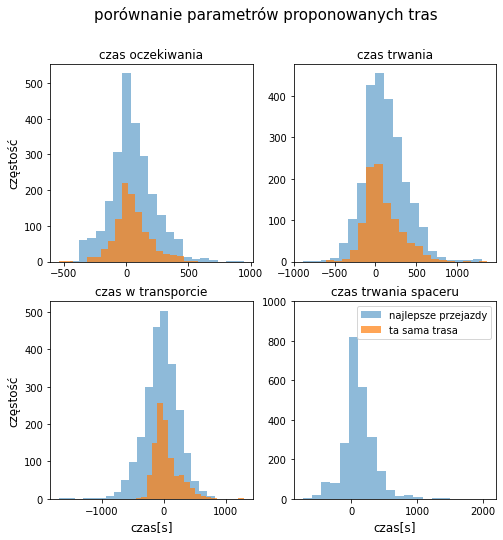

In [21]:
fig, axes= plt.subplots(2,2)
fig.set_size_inches(8,8)
cmap_name = 'tab20'
cmap = plt.get_cmap(cmap_name)
cmap = cmap.colors
min_indices = rt_df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()
filtered_rt_df = rt_df.loc[min_indices]
min_indices = df.groupby(['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'])['duration'].idxmin()
filtered_df = df.loc[min_indices]

d = {
    'waitingTime_diff': 'czas oczekiwania',
    'duration_diff': 'czas trwania',
    'transitTime_diff': 'czas w transporcie',
    'walkTime_diff': 'czas trwania spaceru'
}

merged_df = filtered_df.merge(filtered_rt_df, on = ['requestParameters.date', 'requestParameters.time', 'location_from_name', 'location_to_name'], how = 'inner', suffixes=['_expected', '_real'])
merged_df['waitingTime_diff'] = merged_df['waitingTime_real'] - merged_df['waitingTime_expected']
merged_df['duration_diff'] = merged_df['duration_real'] - merged_df['duration_expected']
merged_df['transitTime_diff'] = merged_df['transitTime_real'] - merged_df['transitTime_expected']
merged_df['walkTime_diff'] = merged_df['walkTime_real'] - merged_df['walkTime_expected']
best_df = merged_df
print(f'Jaki procent najlepszych tras planowo pozostaje najlepszymi trasami w zestawie rzeczywistym {round(100*np.mean(merged_df["route_coordinates_expected"] == merged_df["route_coordinates_real"]))}')

for ax, colname in zip(np.asarray(axes).flatten(), ['waitingTime_diff', 'duration_diff',  'transitTime_diff', 'walkTime_diff']):
    print(d.get(colname), round(np.mean(merged_df[colname]), 2), 's')
    ax.hist(merged_df[colname], alpha = 0.5, label = 'najlepsze przejazdy', color = cmap[0], bins = 20)

same_df = df.merge(rt_df, on = ['requestParameters.date', 'requestParameters.time', 'route_coordinates_str'], how = 'inner', suffixes=['_expected', '_real'])
same_df['waitingTime_diff'] = same_df['waitingTime_real'] - same_df['waitingTime_expected']
same_df['duration_diff'] = same_df['duration_real'] - same_df['duration_expected']
same_df['transitTime_diff'] = same_df['transitTime_real'] - same_df['transitTime_expected']
same_df['walkTime_diff'] = same_df['walkTime_real'] - same_df['walkTime_expected']
print(f'jaki procent wszystkich tras planowych znajduje swoje odzwierciedlenie w danych rzeczywistych {round(100*same_df.shape[0]/df.shape[0])}')    

for ax, colname in zip(np.asarray(axes).flatten(), ['waitingTime_diff', 'duration_diff',  'transitTime_diff', 'walkTime_diff']):
    
    print(d.get(colname), round(np.mean(same_df[colname]), 2), 's')
    ax.hist(same_df[colname], alpha = 0.7, label = 'ta sama trasa', color = cmap[2], bins = 20)
    # ax.axvline(df[colname].mean(), color = cmap[0], zorder = 3, linewidth = 2)
    # ax.axvline(rt_df[colname].mean(), color = cmap[2], zorder = 3, linewidth = 2)
    
    # t = ax.text(s = f"{round(df[colname].mean())}s", color = cmap[0], x = ax.get_xlim()[1], y = (ax.get_ylim()[0] + ax.get_ylim()[1]) / 2, ha = 'right', va = 'bottom', fontsize = 10)
    # t.set_bbox(dict(facecolor='black', alpha = 0.3, edgecolor='black'))



    ax.set_title(f'{d.get(colname)}', fontsize = 12)
    # print(f'{colname} gtfs {round(np.mean(df[colname] ))}s\t rt-gtfs {round(np.mean(rt_df[colname] ))}s')
    

axes[0,0].set_ylabel('częstość', fontsize = 12)
axes[1,0].set_ylabel('częstość', fontsize = 12)
axes[1,0].set_xlabel('czas[s]', fontsize = 12)
axes[1,1].set_xlabel('czas[s]', fontsize = 12)
axes[1,1].set_ylim(0, 1000)
plt.suptitle('porównanie parametrów proponowanych tras', fontsize = 15)
plt.legend(loc = 'upper right')
plt.savefig('../outputs/OTP/benchmark/delays_comparison_full.png', dpi = 300)
plt.show()


In [22]:
from scipy.stats import ttest_ind

variables = ['waitingTime_diff', 'duration_diff', 'transitTime_diff', 'walkTime_diff']

for variable in variables:
    t_statistic, p_value = ttest_ind(best_df[variable], same_df[variable], equal_var = False)
    print(f'Test for {variable}: t-statistic = {t_statistic}, p-value = {p_value}')

Test for waitingTime_diff: t-statistic = 0.677581161013799, p-value = 0.49810210014223466
Test for duration_diff: t-statistic = 2.855909645828109, p-value = 0.004331277076139327
Test for transitTime_diff: t-statistic = -9.980345308721382, p-value = 4.751094184089262e-23
Test for walkTime_diff: t-statistic = 20.694078430733107, p-value = 1.096136493955007e-87


# Kolmogorov - Smirnov test for ECDF's of routes, as compared between GTFS and RT-GTFS

waitingTime 0.07290889819577463 1.7977835502130672e-20
duration 0.13681060750455076 4.051165016941541e-71
transitTime 0.1017781350297222 1.661489113566991e-39
walkTime 0.08169577164927595 1.3490930957946306e-25


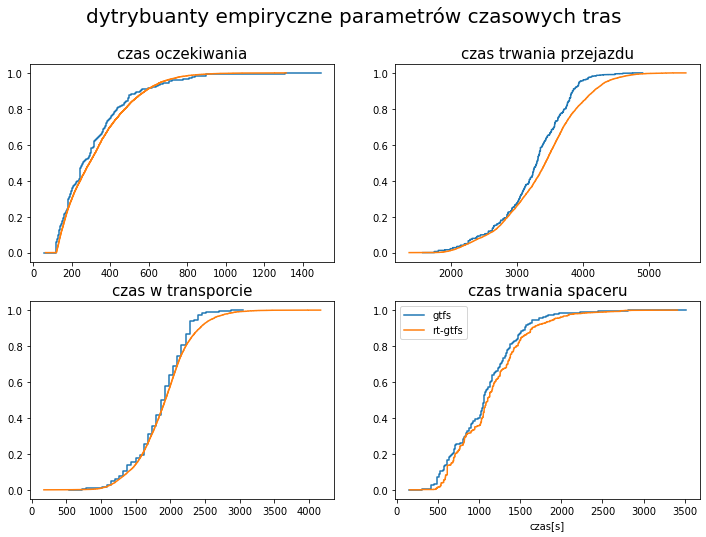

In [23]:
from scipy import stats
import matplotlib.pyplot as plt
import itertools
# Assuming df and rt_df are your DataFrames
fig, axes = plt.subplots(2,2)
fig.set_size_inches(12,8)
# Extracting samples for 'gtfs' and 'rt-gtfs'
d = {
    'waitingTime': 'czas oczekiwania',
    'duration': 'czas trwania przejazdu',
    'transitTime': 'czas w transporcie',
    'walkTime': 'czas trwania spaceru'
}
for ax, col in zip(np.array(axes).flatten(), ['waitingTime', 'duration',  'transitTime', 'walkTime']):
    samples = [
        df[col],
        rt_df[col]
    ]

    # Creating ECDFs
    ecdfs = [stats.ecdf(sample) for sample in samples]

    # Plotting ECDFs
    for ecdf, name in zip(ecdfs, ['gtfs', 'rt-gtfs']):
        ecdf.cdf.plot(ax=ax)
    ax.set_title(f'{d.get(col)}', fontsize = 15)
    p_val = []
    ks_stat = []
    for i in range(len(samples)):
        l1 = np.array(list(itertools.chain(*samples[0:i])) + list(itertools.chain(*samples[i+1::])))
        l2 = np.array(list(samples[i]))
        res = stats.kstest(rvs = l1, cdf = l2)
        p_val.append(res.pvalue)
        ks_stat.append(res.statistic)
    print(col, res.statistic, res.pvalue)

plt.suptitle("dytrybuanty empiryczne parametrów czasowych tras", fontsize = 20)
plt.legend(['gtfs', 'rt-gtfs'])
plt.xlabel('czas[s]')
plt.savefig('../outputs/OTP/benchmark/ecdf_parameters.png', dpi=300)

plt.show()